# Ukrainian telegram messages research
#### Vynokury

---

## Intro

#### Goal

Our main goal was to learn how to work with a real dataset and dive deeper into the functionality of Pandas.

To do this, we focused on two aspects during the analysis:

- Dataset cleaning
- Weather analysis
- Linguistic analysis

#### Executors
All tasks were performed with the participation of all team members, all participants applied the same level of effort.

- Nikita Lenyk - Linguistic analysis
- Ostap Kostiuk - Data cleaning and presentation
- Andrii Kryvyi - Data cleaning and visualisation
- Luka Konovalov - Weather analysis

#### Requirements
This notebook requires these modules to be installed:
- pandas
- matplotlb
- geopandas
- nltk
- pymorphy3
- pymorphy3-dicts-uk
- wordcloud

In [1]:
%pip install pandas matplotlib geopandas pymorphy3 pymorphy3-dicts-uk nltk wordcloud


[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Initializing

In this part we initialize required modules, read dataset and clean it (analyzing it dirtiness).

### Setuping Jupyter Notebook

In [2]:
%config InlineBackend.figure_formats = ['svg']

### Import modules

In [3]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import nltk
import re
import pymorphy3
import wordcloud

### Initialize NLP modules

In [4]:
nltk.download("punkt")

morph = pymorphy3.MorphAnalyzer(lang="uk")

[nltk_data] Downloading package punkt to /var/home/andriy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read map of Ukraine

In [5]:
iso_regions = {
    "UA-65": "Херсонська",
    "UA-07": "Волинська",
    "UA-56": "Рівненська",
    "UA-18": "Житомирська",
    "UA-32": "Київська",
    "UA-74": "Чернігівська",
    "UA-59": "Сумська",
    "UA-63": "Харківська",
    "UA-09": "Луганська",
    "UA-14": "Донецька",
    "UA-23": "Запорізька",
    "UA-46": "Львівська",
    "UA-26": "Івано-Франківська",
    "UA-21": "Закарпатська",
    "UA-61": "Тернопільська",
    "UA-77": "Чернівецька",
    "UA-51": "Одеська",
    "UA-48": "Миколаївська",
    "UA-43": "Автономна Республіка Крим",
    "UA-05": "Вінницька",
    "UA-68": "Хмельницька",
    "UA-71": "Черкаська",
    "UA-53": "Полтавська",
    "UA-12": "Дніпропетровська",
    "UA-35": "Кіровоградська",
    "UA-30": "Київ",
    "UA-40": "Севастополь",
}

map_ = gpd.read_file("ukrainian_map.geojson")
map_["region"] = map_.shapeISO.map(iso_regions)
map_ = map_.drop(
    columns=["shapeName", "shapeISO", "shapeID", "shapeGroup", "shapeType"]
)
map_

,geometry,region
0,"POLYGON ((35.23342 45.79173, 35.22632 45.81739...",Херсонська
1,"POLYGON ((25.11276 50.28727, 25.11147 50.29428...",Волинська
2,"POLYGON ((25.11276 50.28727, 25.11291 50.28489...",Рівненська
3,"POLYGON ((27.19595 50.56224, 27.19661 50.55239...",Житомирська
4,"MULTIPOLYGON (((30.34907 50.48887, 30.34605 50...",Київська
5,"POLYGON ((32.14266 50.34881, 32.2184 50.35759,...",Чернігівська
6,"POLYGON ((33.06618 50.51985, 33.06913 50.51844...",Сумська
7,"POLYGON ((34.94082 50.15259, 34.93279 50.13471...",Харківська
8,"POLYGON ((37.87444 49.23388, 37.87342 49.22317...",Луганська
9,"POLYGON ((36.73891 48.62595, 36.74531 48.59654...",Донецька


### Read dataset

Dataset is placed in the `message-weather.csv` file in a csv format.

In [6]:
dataset = pd.read_csv("message-weather.csv")
dataset

,city,date_weather,latitude_decimal,longitude_decimal,max_temperature,min_temperature,region_x,temperature,wind_direction,wind_speed,weather_description,date_hour_x,tg_message
0,Суми,2022-12-02 12:32,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,Херсон,2023-04-01 09:06,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...
8801,Херсон,2023-03-10 08:43,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


### Clean columns

First of all, we rename columns `tg_message` to `message_text`, `latitude_decimal` to `latitude`, `longitude_decimal` to `longitude` and `region_x` to `region` for names to be understandable and easy-to-use.

In [7]:
dataset = dataset.rename(
    columns={
        "tg_message": "message_text",
        "latitude_decimal": "latitude",
        "longitude_decimal": "longitude",
        "region_x": "region",
    }
)

There is also a problem with parsing `date_weather` and `date_hour_x`, since those are strings, but have to be dates, so we convert them:

In [8]:
dataset.date_weather = pd.to_datetime(dataset.date_weather, format="%Y-%m-%d %H:%M")
dataset.date_hour_x = pd.to_datetime(dataset.date_hour_x, format="%Y-%m-%d %H:%M:%S")

Now the dataset looks like this:

In [9]:
dataset

,city,date_weather,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,date_hour_x,message_text
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,Херсон,2023-04-01 09:06:00,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20:00,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...
8801,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


## Examination

For further cleanup, it would be great to examine data.

### Dates

We can see that the `date_weather` is precise date (minute precision), but in comparison `date_hour_x` is not (hour precision). It would be great to examine their relation in the dataset:

count                         8803
mean     0 days 00:30:25.239123026
std      0 days 00:17:11.615431718
min                0 days 00:00:00
25%                0 days 00:15:00
50%                0 days 00:32:00
75%                0 days 00:45:00
max                0 days 00:59:00
dtype: object

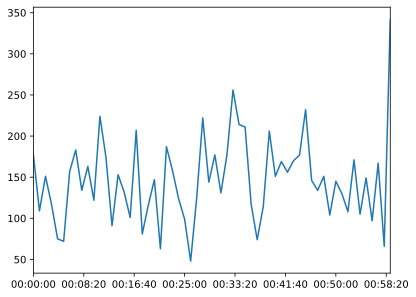

In [10]:
diff = dataset["date_weather"] - dataset["date_hour_x"]
dataset.groupby(diff).count().plot.line(y="message_text", legend=False)
diff.describe()


Since the `date_weather` stands between `date_hour_x` and `date_hour_x + 1h` (if we look at the maximum value of the difference) we can suppose, that `date_hour_x` actually equals `date_weather` without minutes component. So let's check this:

In [11]:
(dataset["date_weather"].dt.floor("h") == dataset["date_hour_x"]).describe()

count     8803
unique       1
top       True
freq      8803
dtype: object

We can see that there is only 1 unique element (True), that means, that this equality is true for all records in the dataset.

Because of this, we can say, that there is an error in the data: weather information is usually measured every hour in 0 minutes, but messages are usually sent in different time, so probably `date_hour_x` must be a time when weather was measured and `date_weather` a time when message was sent. This would explain why `date_hour_x` equals `date_weather` without minutes component: when data was collected, recent weather information was used.

To not get confused later, we rename `date_hour_x` to `weather_time` and `date_weather` to `message_time`.

In [12]:
dataset = dataset.rename(
    columns={
        "date_hour_x": "weather_time",
        "date_weather": "message_time",
    }
)

In final, we have normalized columns names and got this kind of table:

In [13]:
dataset

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
4,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8798,Херсон,2023-04-01 09:06:00,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20:00,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...
8801,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


### Duplicates
It would be great to check whether there are duplicates in the table.

In [14]:
dataset.duplicated().sum()

np.int64(4458)

And in fact, there are a lot of them, so we clean it:

In [15]:
old_size = len(dataset.index)
dataset.drop_duplicates(inplace=True)
new_size = len(dataset.index)

print(f"{old_size} -> {new_size}, {(1 - new_size/old_size) * 100:.2f}%")

8803 -> 4345, 50.64%


We can see, that the dataset size was reduced from 8803 records to 4345 (by 50.64%), meaning that half of the data were duplicates of the same records.

### Regions
It would be great to look how many mentions are there for different regions.

<Axes: >

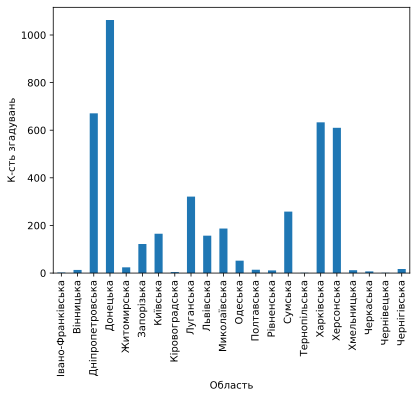

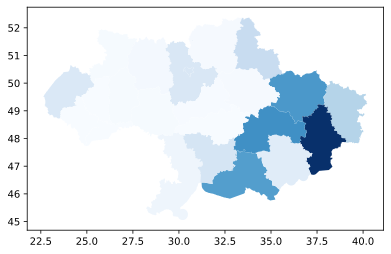

In [16]:
messages_per_region = dataset.groupby("region").count()["message_text"]
messages_per_region.plot.bar(xlabel="Область", ylabel="К-сть згадувань", legend=False)
messages_per_region["Київ"] = messages_per_region["Київська"]
messages_map = map_.join(messages_per_region, on="region")

messages_map.plot("message_text", cmap="Blues")

So we can see, that almost all the data is from the eastern and southern regions of Ukraine. In future we will focus only on those regions, so we filter them out.

In [17]:
eastern_regions = [
    "Сумська",
    "Харківська",
    "Дніпропетровська",
    "Донецька",
    "Луганська",
    "Запорізька",
    "Херсонська",
    "Миколаївська",
]
dataset = dataset[dataset.region.isin(eastern_regions)]
dataset

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
2,Дніпро,2022-12-02 11:33:00,48.466111,35.025278,1.7,-1.6,Дніпропетровська,1.7,357,29.9,Partly cloudy,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
3,Нікополь,2022-12-02 11:33:00,47.577222,34.357500,2.4,0.1,Дніпропетровська,2.4,7,25.4,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
5,Суми,2022-12-02 11:31:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,342,28.7,Overcast,2022-12-02 11:00:00,"💥 Сумська обл.\nСумський район, загроза артиле..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8796,Козацьке,2023-04-01 14:59:00,46.786667,33.332222,19.6,10.8,Херсонська,18.9,244,37.2,Mainly clear,2023-04-01 14:00:00,росіяни обстрілюють Херсонщину. \n\nЗ артилері...
8797,Херсон,2023-04-01 09:06:00,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...
8799,Херсон,2023-03-30 16:20:00,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...


So we are left with 3865 records from eastern regions.

### Unique messages

Also there might be other kinds of duplicates. Since the main column of the dataset is telegram message and time when it was sent, we examine how many unique messages are there.

Note: we suppose that probability of two identical text messages being sent at the same time and being in this dataset is pretty low.

In [18]:
(dataset.groupby(["message_text", "message_time"]).size() > 0).sum()

np.int64(1618)

This means, that from 3865 messages there are only around 1618 unique. But since those are not strong duplicates, we can lookup for the difference between them.

In [19]:
# Take the group of the maximum size
group = max(
    dataset.groupby(["message_text", "message_time"]).groups.values(),
    key=lambda item: len(item),
)
dataset.loc[group[:7]]

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text
8539,Нововознесенське,2023-02-23 14:29:00,47.428333,33.601389,9.7,2.4,Херсонська,9.3,140,11.8,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8540,Берислав,2023-02-23 14:29:00,46.841389,33.429444,10.0,4.0,Херсонська,9.6,113,11.8,Clear sky,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8541,Томарине,2023-02-23 14:29:00,46.874444,33.304167,10.1,4.0,Херсонська,9.7,116,11.6,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8542,Борозенське,2023-02-23 14:29:00,47.178611,33.419722,10.0,2.9,Херсонська,9.5,130,11.2,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8543,Білоусове,2023-02-23 14:29:00,47.326111,33.238333,10.2,2.4,Херсонська,9.7,136,11.5,Mainly clear,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8544,Біляївка,2023-02-23 14:29:00,47.324444,33.701944,9.7,3.0,Херсонська,9.3,127,11.3,Clear sky,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."
8545,Херсон,2023-02-23 14:29:00,46.640000,32.614444,10.2,3.4,Херсонська,9.8,128,10.5,Partly cloudy,2023-02-23 14:00:00,"Працюємо, аби повернути нормальне життя на зві..."


And the message was:

In [20]:
print(dataset.loc[group[0], "message_text"])

Працюємо, аби повернути нормальне життя на звільнену Херсонщину. Детальніше про те, що зроблено 22 лютого👇

⏺Для відновлення світла на Херсонщині працює 38 бригади – це 185 робітників та 69 одиниць техніки. Минулої доби бригади працювали на лініях, що живлять Нововознесенське, Берислав, Томарине, Борозенське, Білоусове, Біляївку, Миролюбівку, Херсон, Правдине, Молодецьке та Посад-Покровське.

⏺Енергетики відновили електропостачання у 3 населених пунктах Херсонщини – Миролюбівці Нововоронцовської громади,  Інгулівці та Лиманцю Дарʼївської громади. Загалом до мережі підʼєднали 785 абонентів. 

⏺За дорученням начальника Херсонської ОВА, над відновленням будівель, що понівечені через російські удари, у Херсоні працювали 35 робітників з Херсонської обласної комунальної аварійно-рятувальної служби та ДСНС. Першочергові ремонтні роботи проведено за 14 адресами. Загалом закрито OSB-листами 172 вікна, з них 11 – у будинку профспілок, 42 – у будівлі УТОС, 35 – у дитсадках, 16 – у адміністративні

We can see, that the difference is in the city names (and hence the weather). All of the cities in the group were mentioned in the message, so it probably means that those duplicates just mean different towns. We can check this hypothesis by checking whether there are duplicates of values in the form of `(message_time, message_text, city)`:

In [21]:
dataset.duplicated(["message_time", "message_text", "city"]).any()

np.False_

In fact, there are no duplicates of that form, so the dataset actually looks like this:

In [22]:
dataset.set_index(["message_time", "message_text", "city"]).head(5)

latitude  \
message_time        message_text                                       city                   
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми       50.911944   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець  47.644722   
                                                                       Дніпро     48.466111   
                                                                       Нікополь   47.577222   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми       50.911944   

                                                                                  longitude  \
message_time        message_text                                       city                   
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми       34.803333   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець  34.604167   
                                                                       Дніпро     35.025278   
                                                                       Нікополь   34.357500   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми       34.803333   

                                                                                  max_temperature  \
message_time        message_text                                       city                         
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми                  -0.2   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець              2.7   
                                                                       Дніпро                 1.7   
                                                                       Нікополь               2.4   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми                  -0.2   

                                                                                  min_temperature  \
message_time        message_text                                       city                         
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми                  -3.3   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець             -0.1   
                                                                       Дніпро                -1.6   
                                                                       Нікополь               0.1   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми                  -3.3   

                                                                                            region  \
message_time        message_text                                       city                          
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми                Сумська   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець  Дніпропетровська   
                                                                       Дніпро     Дніпропетровська   
                                                                       Нікополь   Дніпропетровська   
2022-12-02 11:31:00 💥 Сумська обл.\nСумський район, загроза артилер... Суми                Сумська   

                                                                                  temperature  \
message_time        message_text                                       city                     
2022-12-02 12:32:00 💥 Хотінь (Сумська обл.)\nЗагроза артилерійськог... Суми              -0.2   
2022-12-02 11:33:00 💥 Марганець (Дніпропетровська обл.)\nЗагроза ар... Марганець          2.7   
                                                                       Дніпро             1.7   
                                                                       Нікополь           2.4   
2022-12-02 11:31:00 💥 Сумська обл.\nСу

However we won't update the indices of the dataset, since it is easier to work with denormalized data in pandas, but it would be great to have another copy of the dataset, that contains only those 1618 unique messages.

In [23]:
dataset_messages = dataset[["message_time", "message_text"]].drop_duplicates()
dataset_messages

,message_time,message_text
0,2022-12-02 12:32:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
1,2022-12-02 11:33:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...
5,2022-12-02 11:31:00,"💥 Сумська обл.\nСумський район, загроза артиле..."
6,2022-12-02 11:21:00,💥 Очаків (Миколаївська обл.)\nЗагроза артилері...
8,2022-12-02 09:32:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...
...,...,...
8795,2023-04-01 14:59:00,росіяни обстрілюють Херсонщину. \n\nЗ артилері...
8797,2023-04-01 09:06:00,Херсонська область. Інформація щодо ворожих об...
8799,2023-03-30 16:20:00,​​⚡️Отримав осколкове поранення під час бомбар...
8800,2023-03-10 08:43:00,Херсонська область. Інформація щодо ворожих об...


### Finalization

We finished with data cleaning, but also we would like to show the plot of the messages received per day.

<Axes: xlabel='Дата', ylabel='К-сть повідомлень'>

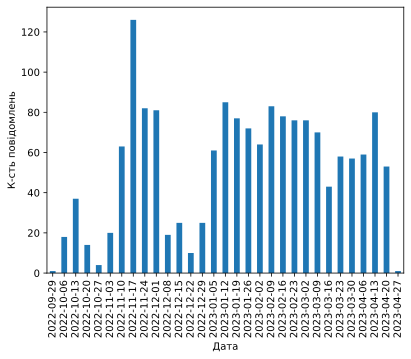

In [24]:
dataset_messages.groupby(dataset_messages.message_time.dt.round("7d").dt.date).count().plot.bar(
    y="message_text", legend=False, xlabel="Дата", ylabel="К-сть повідомлень"
)

## Linguistics analysis

In this part, we will analyze texts of the messages given in the dataset.

### Word usage frequencies

We analyze how frequently words are used by nltk library and Ukrainian dictionary. This creates a new column `words`, which contains Counter, where the key is word and the value is a number of times it was used.

In [25]:
def tokenize_and_lemmatize(text):
    tokens = nltk.word_tokenize(text.lower())
    lemmas = Counter()
    for token in tokens:
        if not token.isalpha():
            continue

        lemma = morph.parse(token)[0].normal_form
        lemmas[lemma] += 1

    return lemmas

dataset_messages["words"] = dataset_messages.message_text.apply(tokenize_and_lemmatize)

Also we join dataset_messages back to dataset to use words in future with region information.

In [26]:
dataset = dataset.join(dataset_messages.set_index(["message_time", "message_text"]), on=["message_time", "message_text"])

Now we can create plot of often used words:

<Axes: >

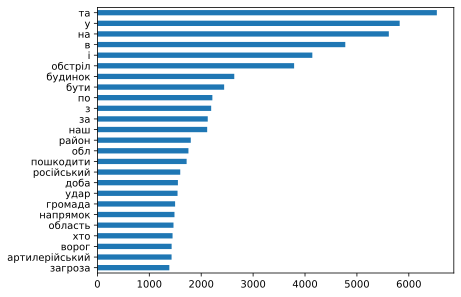

In [27]:
words = pd.Series(dataset_messages.words.sum())
words = words.sort_values()
words.iloc[-25:].plot.barh()

We can see, that there are lots of words connected to the war in theese messages.

#### WordCloud

We also create a wordcloud to see the general mood the messages reflect.

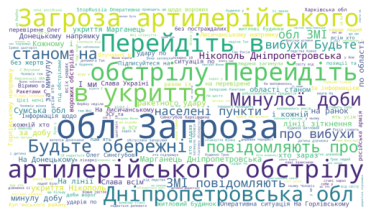

In [28]:
text_data = " ".join(dataset_messages['message_text'])

picture = wordcloud.WordCloud(width=1920, height=1080, background_color="white").generate(text_data)

plt.imshow(picture)
plt.axis("off")
plt.show()

#### Threats counting

We create a set of tokens, that mean some type of threat, and then count how many messages are about threats.

In [29]:
threats_lemmas = {"обстрілюваний", "атакований", "обстріллючи", "артобстріл", "атакувати", "обстрілювати", "атака", "вибух", "обстріляти", "загроза", "обстріл"}
dataset_messages.words.apply(lambda lemmas: bool(set(lemmas.keys()) & threats_lemmas)).value_counts()

words
True     1514
False     104
Name: count, dtype: int64

We can see, that only 104 messages don't contain those lemmas.

### Injured people and casualties counting

We want to count injured people and casualties in the messages:

np.int64(1186)

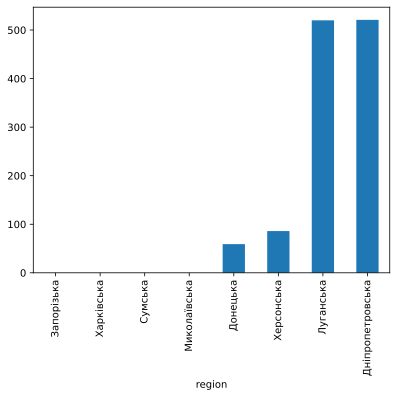

In [30]:
dataset_regions = dataset[["message_time", "message_text", "region"]].drop_duplicates()

def extract_injured_count(text):
    match = re.search(r"\b(\d+)\s*(?:поранені|поранених)\b", str(text), re.IGNORECASE)
    return int(match.group(1)) if match else 0

dataset_regions = dataset_regions.assign(injured_count = dataset_regions.message_text.apply(extract_injured_count))
injured_by_region = dataset_regions.groupby("region")["injured_count"].sum()
total_injured = injured_by_region.sum()
injured_by_region.sort_values().plot.bar()
total_injured

We can see that the most injured people are in Luhansk and Dnipropetrovsk oblast.

np.int64(164)

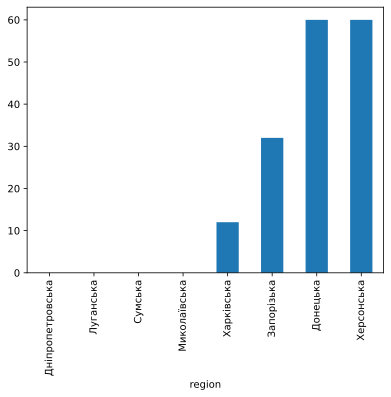

In [31]:
dataset_regions = dataset[["message_time", "message_text", "region"]].drop_duplicates()

def extract_casualties_count(text):
    match = re.search(r"\b(\d+)\s*(?:людей\s*)?(?:загинули|загинуло)|(?:загинули|загинуло)\s*(\d+)\b", str(text), re.IGNORECASE)
    if match:
        return int(match.group(1) or match.group(2))
    return 0

dataset_regions = dataset_regions.assign(casualties_count = dataset_regions.message_text.apply(extract_casualties_count))
casualties_by_region = dataset_regions.groupby("region")["casualties_count"].sum()
total_casualties = casualties_by_region.sum()
casualties_by_region.sort_values().plot.bar()
total_casualties

We can see that the most casualties are in Zaporizha, Donetsk, and Kherson oblast.

## Weather analysis

We create a dataset for unique weather records for each region at each time period.

In [32]:
weather_dataset = dataset.drop_duplicates(['weather_time', 'region'])
weather_dataset

,city,message_time,latitude,longitude,max_temperature,min_temperature,region,temperature,wind_direction,wind_speed,weather_description,weather_time,message_text,words
0,Суми,2022-12-02 12:32:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,343,31.2,Overcast,2022-12-02 12:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...,"{'хотіння': 1, 'сумський': 1, 'обл': 1, 'загро..."
1,Марганець,2022-12-02 11:33:00,47.644722,34.604167,2.7,-0.1,Дніпропетровська,2.7,3,28.5,Overcast,2022-12-02 11:00:00,💥 Марганець (Дніпропетровська обл.)\nЗагроза а...,"{'марганець': 1, 'дніпропетровський': 2, 'обл'..."
5,Суми,2022-12-02 11:31:00,50.911944,34.803333,-0.2,-3.3,Сумська,-0.2,342,28.7,Overcast,2022-12-02 11:00:00,"💥 Сумська обл.\nСумський район, загроза артиле...","{'сумський': 2, 'обл': 1, 'район': 1, 'загроза..."
6,Очаків,2022-12-02 11:21:00,46.618611,31.539167,3.8,0.9,Миколаївська,3.4,49,23.2,Overcast,2022-12-02 11:00:00,💥 Очаків (Миколаївська обл.)\nЗагроза артилері...,"{'очаків': 1, 'миколаївський': 1, 'обл': 1, 'з..."
8,Хотінь,2022-12-02 09:32:00,51.078056,34.775833,-0.2,-3.3,Сумська,-1.1,342,31.1,Overcast,2022-12-02 09:00:00,💥 Хотінь (Сумська обл.)\nЗагроза артилерійсько...,"{'хотіння': 1, 'сумський': 2, 'обл': 2, 'загро..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,Херсон,2023-04-01 14:59:00,46.640000,32.614444,18.1,10.2,Херсонська,17.2,247,40.7,Clear sky,2023-04-01 14:00:00,росіяни обстрілюють Херсонщину. \n\nЗ артилері...,"{'росіянин': 1, 'обстрілювати': 1, 'херсонщина..."
8797,Херсон,2023-04-01 09:06:00,46.640000,32.614444,18.1,10.2,Херсонська,16.9,248,45.4,Mainly clear,2023-04-01 09:00:00,Херсонська область. Інформація щодо ворожих об...,"{'херсонський': 2, 'область': 1, 'інформація':..."
8799,Херсон,2023-03-30 16:20:00,46.640000,32.614444,16.2,3.1,Херсонська,10.7,245,27.7,Mainly clear,2023-03-30 16:00:00,​​⚡️Отримав осколкове поранення під час бомбар...,"{'осколковий': 4, 'поранення': 4, 'під': 6, 'ч..."
8800,Херсон,2023-03-10 08:43:00,46.640000,32.614444,-1.5,-6.3,Херсонська,-2.7,65,36.1,Overcast,2023-03-10 08:00:00,Херсонська область. Інформація щодо ворожих об...,"{'херсонський': 4, 'область': 4, 'інформація':..."


So we actually have only 1313 records of weather. Let's try to look at wind rose:

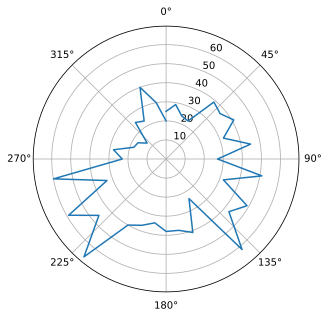

In [33]:
wind_data = weather_dataset['wind_direction'].round(-1).value_counts().sort_index()
ax = plt.axes(projection="polar")
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.plot(np.deg2rad(wind_data.index),wind_data.values,)

We can see that most of the winds are directed to south-west. Let's see which wind speed tends to be there.

np.float64(24.331703703703703)

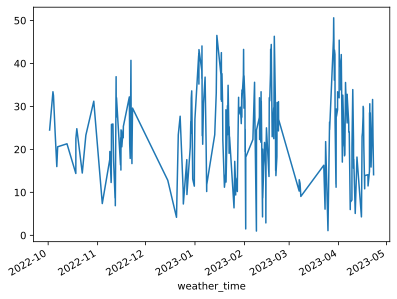

In [34]:
north_east_wind_speed = weather_dataset[(180<weather_dataset['wind_direction']) & (weather_dataset['wind_direction'] <= 270)].groupby("weather_time").wind_speed.mean()
north_east_wind_speed.plot.line()
north_east_wind_speed.mean()

We can see that there is a weather gap between December and March. The mean speed of the weather is 25 (while the speed itself is between 0 and 50 km/h). We suppose that wind is measured in km/h because 50 m/s is very anomalous wind (hurricane), there is a low possibility of that. 

Also we want to see a temperature plot for Eastern Ukraine:

<Axes: >

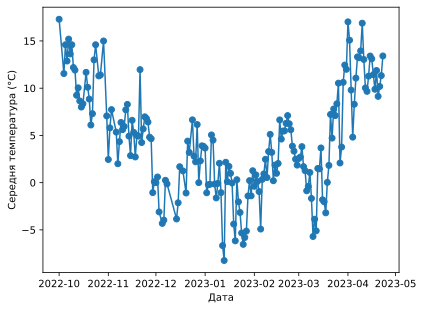

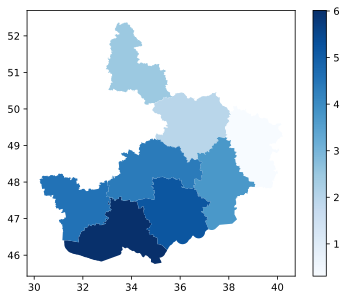

In [35]:
weather_dataset.assign(date=weather_dataset['message_time'].dt.date).groupby('date')['temperature'].mean().plot(kind='line', marker='o', xlabel="Дата", ylabel='Середня температура (°C)')

temperature_per_region = dataset.groupby("region")["temperature"].mean()
temperature_map = map_.join(temperature_per_region, on="region")
temperature_map.plot("temperature", cmap="Blues", legend=True)